# A Socio-economic Analysis of Chicago

## Table of contents
* [Introduction](#introduction)
* [Data Sources](#datasources)
* [Predicting the hardship index of a community](#goal1)
    * [Data acquistion and cleaning](#goal1_data)
    * [Data exploration and visualization](#goal1_eda_viz)
    * [Analysis](#goal1_analysis)
* [Predicting useful locations of public parks in the city](#goal2)
    * [Data acquisition and cleaning](#goal2_data)
    * [Data exploration and visualization](#goal2_eda_viz)
    * [Analysis](#goal2_analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction<a name="introduction"></a>

The socio-economic status of a region, be it a city, country, or anything like it, can be a powerful gauge of the efficiency of governments, business, and economic policy. Researchers have recently begun leveraging the power of machine learning to analyze the effects of economic and financial changes on the well-being of a population, and vice versa. Understanding this multi-faceted relationship is of utmost importance in creating and maintaining a fair social structure, along with a happy citizenry, which will only result in the further growth of the region.

In this project, the city of Chicago will be studied between 2008-2012, and the effects of various socio-economic factors on the health and so-called “hardship index” of its citizens will be explored. The project has two aims. The first is the prediction of the hardship index of a neighbourhood based on the interplay of a number of factors, including per capita income, poverty level, and housing situation. Additionally, the universally beneficial effect of public parks on the economic, environmental and mental well-being of a community's residents is well-documented; see [1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6121520/) and [2](https://www.nrpa.org/uploadedFiles/nrpa.org/Advocacy/Resources/Parks-Recreation-Essential-Public-Services-January-2010.pdf), for example. The second aim of the project is thus to guide city authorities by suggesting locations to open new parks.

An analysis such as this would be of use to a number of groups: governments can use it to guide policy formulation, businesses can use it to enter markets that would benefit from their presence, and the citizens themselves can use it to understand their community better, perhaps forming their own groups to improve their situation, or that of their neighbours.

## Data sources<a name="datasources"></a>

The following data sources are used in this project:
- Census data for Chicago between 2008-2012, obtained from [the city’s data portal](https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2/data).
- Crime data for the city between 2008-2012, obtained from [Kaggle](https://www.kaggle.com/currie32/crimes-in-chicago).
- Chicago public school data for the academic year 2011-2012, obtained from [the city’s data portal](https://data.cityofchicago.org/Education/Chicago-Public-Schools-Progress-Report-Cards-2011-/9xs2-f89t/data).
- The list of neighbourhoods by community area in Chicago, scraped from [Wikipedia](https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago).
- The list of public parks in a 500 m radius of each neighbourhood, obtained using the Foursquare API.

In [261]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import geocoder
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from statistics import mean
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium.plugins import FeatureGroupSubGroup
from folium.plugins import HeatMap
import utm
import math
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

## Predicting the hardship index of a community based on socio-economic factors<a name="goal1"></a>

### Data acquisition and cleaning<a name="goal1_data"></a>

Let's begin by importing the census data.

In [4]:
census_data = pd.read_csv('ChicagoCensusData.csv')

The **census dataset contains almost wholly relevant information**. It contains the community area name and number, which are needed for cross-referencing data in the crime and school datasets. It also **contains the target variable, the hardship index**, which is given for each of Chicago’s 77 communities, along with some key indicators, such as the percentage of households below the poverty line, the average per capita income, and the percentage of people living in crowded households.

In [5]:
census_data.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16__UNEMPLOYED,PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


Let's remove extra underscores in a couple of column names.

In [6]:
census_data = census_data.rename(columns={"PERCENT_AGED_16__UNEMPLOYED": "PERCENT_AGED_16_UNEMPLOYED",
                            "PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA": "PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA"})

In [7]:
census_data.tail()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
73,74.0,Mount Greenwood,1.0,3.4,8.7,4.3,36.8,34381,16.0
74,75.0,Morgan Park,0.8,13.2,15.0,10.8,40.3,27149,30.0
75,76.0,O'Hare,3.6,15.4,7.1,10.9,30.3,25828,24.0
76,77.0,Edgewater,4.1,18.2,9.2,9.7,23.8,33385,19.0
77,NaN,CHICAGO,4.7,19.7,12.9,19.5,33.5,28202,NaN


The last row contains aggregate information for the entire city of Chicago. This information is not needed, so the row can be dropped.

In [8]:
census_data = census_data.drop(77)

In [9]:
comm_latitudes = []
comm_longitudes = []

for comm in census_data['COMMUNITY_AREA_NAME']:
    address = "{}, Chicago".format(comm)
    g = geocoder.arcgis(address)
    latlng = g.latlng
    comm_latitudes.append(latlng[0])
    comm_longitudes.append(latlng[1])
    print(comm+" | Latitude: "+str(latlng[0])+", Longitude: "+str(latlng[1]))

Rogers Park | Latitude: 42.00897000000003, Longitude: -87.66618999999997
West Ridge | Latitude: 41.99948000000006, Longitude: -87.69265999999999
Uptown | Latitude: 41.96538000000004, Longitude: -87.66935999999998
Lincoln Square | Latitude: 41.97583000000003, Longitude: -87.68913999999995
North Center | Latitude: 41.95411000000007, Longitude: -87.68141999999995
Lake View | Latitude: 41.939820000000054, Longitude: -87.65681999999998
Lincoln Park | Latitude: 41.92184000000003, Longitude: -87.64743999999996
Near North Side | Latitude: 41.90034000000003, Longitude: -87.63432999999998
Edison Park | Latitude: 42.00789000000003, Longitude: -87.81398999999999
Norwood Park | Latitude: 41.98572000000007, Longitude: -87.80663999999996
Jefferson Park | Latitude: 41.97054000000003, Longitude: -87.76328999999998
Forest Glen | Latitude: 41.97640000000007, Longitude: -87.75360999999998
North Park | Latitude: 41.98294000000004, Longitude: -87.71914999999996
Albany Park | Latitude: 41.968290000000025, Lo

In [10]:
census_data['COMMUNITY_LATITUDE'] = comm_latitudes
census_data['COMMUNITY_LONGITUDE'] = comm_longitudes

In [11]:
census_data.dtypes

COMMUNITY_AREA_NUMBER                          float64
COMMUNITY_AREA_NAME                             object
PERCENT_OF_HOUSING_CROWDED                     float64
PERCENT_HOUSEHOLDS_BELOW_POVERTY               float64
PERCENT_AGED_16_UNEMPLOYED                     float64
PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA    float64
PERCENT_AGED_UNDER_18_OR_OVER_64               float64
PER_CAPITA_INCOME                                int64
HARDSHIP_INDEX                                 float64
COMMUNITY_LATITUDE                             float64
COMMUNITY_LONGITUDE                            float64
dtype: object

Let's also convert the datatype of the COMMUNITY_AREA_NUMBER and HARDSHIP_INDEX columns to integer, since they can never take decimal/floating point values.

In [12]:
census_data = census_data.astype({'COMMUNITY_AREA_NUMBER': int, 'HARDSHIP_INDEX': int})

In [13]:
census_data.dtypes

COMMUNITY_AREA_NUMBER                            int32
COMMUNITY_AREA_NAME                             object
PERCENT_OF_HOUSING_CROWDED                     float64
PERCENT_HOUSEHOLDS_BELOW_POVERTY               float64
PERCENT_AGED_16_UNEMPLOYED                     float64
PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA    float64
PERCENT_AGED_UNDER_18_OR_OVER_64               float64
PER_CAPITA_INCOME                                int64
HARDSHIP_INDEX                                   int32
COMMUNITY_LATITUDE                             float64
COMMUNITY_LONGITUDE                            float64
dtype: object

In [14]:
census_data.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX,COMMUNITY_LATITUDE,COMMUNITY_LONGITUDE
0,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39,42.00897,-87.66619
1,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46,41.99948,-87.69266
2,3,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20,41.96538,-87.66936
3,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17,41.97583,-87.68914
4,5,North Center,0.3,7.5,5.2,4.5,26.2,57123,6,41.95411,-87.68142


We'll persist/save the important datasets as we clean them.

In [15]:
census_data.to_pickle('census_data.pkl')

That's all we need to do with this dataset.

Moving on to the **data regarding crimes in Chicago**, it is **split in two files**: crimes reported between 2008-2011, and crimes reported in 2012. We will **concatenate them after some cleaning**.

The crime datasets contain many columns which do not add value to this analysis, such as the crime ID, FBI code, etc., so let's pick out the **columns which are most useful**. In this case, this is the **community area number**, the **latitude & longitude** of the crime location, and **whether the reported crime eventually led to an arrest**.

In [16]:
crime_data_2008_2011 = pd.read_csv('ChicagoCrimes2008to2011.csv', on_bad_lines='skip', usecols=[9, 14, 20, 21],
                                   low_memory=False)

In [17]:
crime_data_2008_2011.shape

(2688711, 4)

That's a large dataset, but it will shrink in a bit.

In [18]:
crime_data_2008_2011.head()

,Arrest,Community Area,Latitude,Longitude
0,True,69.0,41.758276,-87.622451031
1,True,25.0,41.870252,-87.746069362
2,False,66.0,41.770990,-87.698901469
3,False,25.0,41.894917,-87.757358147
4,False,30.0,41.843826,-87.709893465


In [19]:
crime_data_2008_2011.Arrest.value_counts()

False    1960709
True      728002
Name: Arrest, dtype: int64

The data in this dataset is of all *reported* criminal activity. Since an arrest is a key indicator of a crime actually taking place, those **crimes which were reported but did not lead to an arrest are removed from the dataset**.

In [20]:
crime_data_2008_2011_arrest_true = crime_data_2008_2011.loc[crime_data_2008_2011['Arrest']==True]

In [21]:
crime_data_2008_2011_arrest_true.shape

(728002, 4)

There's still plenty of data left.

Let's check for any NaN values.

In [22]:
crime_data_2008_2011_arrest_true.isna().sum()

Arrest               0
Community Area     269
Latitude          7559
Longitude         7559
dtype: int64

The latitudes and longitudes will be necessary when plotting the locations of crimes on a map of Chicago. The missing values are < 1% of the total; we will not be missing out on anything important if these values are removed. The rows containing these values will be dropped after concatenating this dataset with the data from 2012.

In [23]:
crime_data_2012 = pd.read_csv('ChicagoCrimes2012.csv', on_bad_lines='skip', usecols=[9, 14, 20, 21], low_memory=False)

In [24]:
crime_data_2012.shape

(334628, 4)

In [25]:
crime_data_2012.head()

,Arrest,Community Area,Latitude,Longitude
0,True,19.0,NaN,NaN
1,True,19.0,NaN,NaN
2,False,69.0,NaN,NaN
3,False,30.0,NaN,NaN
4,False,66.0,NaN,NaN


In [26]:
crime_data_2012.Arrest.value_counts()

False    244461
True      90167
Name: Arrest, dtype: int64

In [27]:
# Pick out those crimes which led to an arrest.
crime_data_2012_arrest_true = crime_data_2012.loc[crime_data_2012['Arrest']==True]

In [28]:
crime_data_2012_arrest_true.shape

(90167, 4)

In [29]:
crime_data_2012_arrest_true.isna().sum()

Arrest             0
Community Area     6
Latitude          34
Longitude         34
dtype: int64

In [30]:
# Concatenate the two datasets.
crime_data_list = [crime_data_2008_2011_arrest_true, crime_data_2012_arrest_true]
crime_data_arrest_true = pd.concat(crime_data_list)

In [31]:
crime_data_arrest_true.shape

(818169, 4)

In [32]:
crime_data_arrest_true.Arrest.value_counts()

True    818169
Name: Arrest, dtype: int64

In [33]:
crime_data_arrest_true.isna().sum()

Arrest               0
Community Area     275
Latitude          7593
Longitude         7593
dtype: int64

Let's drop the rows which contain NaN values.

In [34]:
crime_data_arrest_true = crime_data_arrest_true.loc[crime_data_arrest_true['Latitude'].isna()==False]

In [35]:
crime_data_arrest_true.isna().sum()

Arrest              0
Community Area    267
Latitude            0
Longitude           0
dtype: int64

In [36]:
crime_data_arrest_true = crime_data_arrest_true.loc[crime_data_arrest_true['Community Area'].isna()==False]

In [37]:
crime_data_arrest_true.isna().sum()

Arrest            0
Community Area    0
Latitude          0
Longitude         0
dtype: int64

In [38]:
crime_data_arrest_true.shape

(810309, 4)

After all the cleaning, we still have ~ 800k datapoints left.

In [39]:
crime_data_arrest_true.dtypes

Arrest               bool
Community Area    float64
Latitude          float64
Longitude          object
dtype: object

Convert the datatypes of the 'Community Area' and 'Longitude' columns to integer and float respectively.

In [40]:
crime_data_arrest_true = crime_data_arrest_true.astype({'Community Area': int, 'Longitude': float})

In [41]:
crime_data_arrest_true.dtypes

Arrest               bool
Community Area      int32
Latitude          float64
Longitude         float64
dtype: object

Let's **count the total number of crimes** that occured between 2008-2012 **in each community**, and save it to a new dataframe.

In [42]:
crime_total = pd.DataFrame(columns=['NUMBER_OF_CRIMES'])
crime_total['NUMBER_OF_CRIMES'] = crime_data_arrest_true['Community Area'].value_counts()
crime_total = crime_total.reset_index()
crime_total = crime_total.rename(columns={'index': 'Community Area'})

In [43]:
crime_total.tail()

,Community Area,NUMBER_OF_CRIMES
73,74,1139
74,47,996
75,12,695
76,9,381
77,0,8


Apparently, there is a community that has been numbered '0', which is definitely erroneous. Since it only has 8 crimes, let's drop the rows with this value, both in crime_total and crime_data_arrest_true.

In [44]:
crime_data_arrest_true = crime_data_arrest_true.loc[crime_data_arrest_true['Community Area']!=0]
crime_total = crime_total.loc[crime_total['Community Area']!=0]

We can now group the data in by community area number (or, equivalently, community name).

In [45]:
crime_data_arrest_true_grouped = crime_data_arrest_true.groupby(by='Community Area', as_index=False).agg(lambda x: list(x))
crime_data_arrest_true_grouped = crime_data_arrest_true_grouped.merge(crime_total, on='Community Area')

In [46]:
crime_data_arrest_true_grouped.head()

,Community Area,Arrest,Latitude,Longitude,NUMBER_OF_CRIMES
0,1,"[True, True, True, True, True, True, True, Tru...","[42.016030425, 42.013783001, 42.00921913, 42.0...","[-87.66903815, -87.673330073, -87.678068627, -...",12459
1,2,"[True, True, True, True, True, True, True, Tru...","[41.998175246, 41.99767413, 41.990615196, 41.9...","[-87.703330719, -87.693108472, -87.683188577, ...",7030
2,3,"[True, True, True, True, True, True, True, Tru...","[41.964483903, 41.973266096, 41.974104832, 41....","[-87.656888478, -87.65841363, -87.651281486, -...",11507
3,4,"[True, True, True, True, True, True, True, Tru...","[41.980328862, 41.966094642, 41.96768649, 41.9...","[-87.689324892, -87.688828469, -87.693772857, ...",3545
4,5,"[True, True, True, True, True, True, True, Tru...","[41.939535294, 41.943552694, 41.94219754, 41.9...","[-87.681384786, -87.688162342, -87.688249516, ...",2571


Since the dataset has already been filtered for crimes that led to an arrest, that column is now useless, and can be dropped.

In [47]:
crime_data = crime_data_arrest_true_grouped.drop(columns="Arrest")

In [48]:
crime_data.head()

,Community Area,Latitude,Longitude,NUMBER_OF_CRIMES
0,1,"[42.016030425, 42.013783001, 42.00921913, 42.0...","[-87.66903815, -87.673330073, -87.678068627, -...",12459
1,2,"[41.998175246, 41.99767413, 41.990615196, 41.9...","[-87.703330719, -87.693108472, -87.683188577, ...",7030
2,3,"[41.964483903, 41.973266096, 41.974104832, 41....","[-87.656888478, -87.65841363, -87.651281486, -...",11507
3,4,"[41.980328862, 41.966094642, 41.96768649, 41.9...","[-87.689324892, -87.688828469, -87.693772857, ...",3545
4,5,"[41.939535294, 41.943552694, 41.94219754, 41.9...","[-87.681384786, -87.688162342, -87.688249516, ...",2571


Some minor housekeping before we are done: rename the columns in the same style as the census data.

In [49]:
crime_data = crime_data.rename(columns={"Community Area": "COMMUNITY_AREA_NUMBER", "Latitude": "CRIME_LATITUDE",
                           "Longitude": "CRIME_LONGITUDE"})

In [50]:
crime_data.head()

,COMMUNITY_AREA_NUMBER,CRIME_LATITUDE,CRIME_LONGITUDE,NUMBER_OF_CRIMES
0,1,"[42.016030425, 42.013783001, 42.00921913, 42.0...","[-87.66903815, -87.673330073, -87.678068627, -...",12459
1,2,"[41.998175246, 41.99767413, 41.990615196, 41.9...","[-87.703330719, -87.693108472, -87.683188577, ...",7030
2,3,"[41.964483903, 41.973266096, 41.974104832, 41....","[-87.656888478, -87.65841363, -87.651281486, -...",11507
3,4,"[41.980328862, 41.966094642, 41.96768649, 41.9...","[-87.689324892, -87.688828469, -87.693772857, ...",3545
4,5,"[41.939535294, 41.943552694, 41.94219754, 41.9...","[-87.681384786, -87.688162342, -87.688249516, ...",2571


In [51]:
crime_data.to_pickle('crime_data.pkl')

Moving on to the **public school data**, the **important columns** have to be picked out, just as with the crime data. Here, this will be the **name of the school**, the **community area number** in which the school is located, its **latitude and longitude**, the **average student attendance**, and the **number of students who ended up in college**.

In [52]:
public_schools = pd.read_csv('ChicagoPublicSchools.csv', on_bad_lines='skip', usecols=[1, 32, 66, 71, 72, 73])

In [53]:
public_schools.head()

,NAME_OF_SCHOOL,AVERAGE_STUDENT_ATTENDANCE,COLLEGE_ENROLLMENT,Latitude,Longitude,COMMUNITY_AREA_NUMBER
0,Abraham Lincoln Elementary School,96.00%,813,41.924497,-87.644522,7
1,Adam Clayton Powell Paideia Community Academy ...,95.60%,521,41.760324,-87.556736,43
2,Adlai E Stevenson Elementary School,95.70%,1324,41.747111,-87.731702,70
3,Agustin Lara Elementary Academy,95.50%,556,41.809757,-87.672145,61
4,Air Force Academy High School,93.30%,302,41.828146,-87.632794,34


In [54]:
public_schools.dtypes

NAME_OF_SCHOOL                 object
AVERAGE_STUDENT_ATTENDANCE     object
COLLEGE_ENROLLMENT              int64
Latitude                      float64
Longitude                     float64
COMMUNITY_AREA_NUMBER           int64
dtype: object

That '%' sign can be removed, and the average student attendance turned into a float.

In [55]:
public_schools['AVERAGE_STUDENT_ATTENDANCE'] = public_schools['AVERAGE_STUDENT_ATTENDANCE'].str.replace('%', '')
public_schools = public_schools.astype({'AVERAGE_STUDENT_ATTENDANCE': float})

In [56]:
public_schools.dtypes

NAME_OF_SCHOOL                 object
AVERAGE_STUDENT_ATTENDANCE    float64
COLLEGE_ENROLLMENT              int64
Latitude                      float64
Longitude                     float64
COMMUNITY_AREA_NUMBER           int64
dtype: object

In [57]:
public_schools.head()

,NAME_OF_SCHOOL,AVERAGE_STUDENT_ATTENDANCE,COLLEGE_ENROLLMENT,Latitude,Longitude,COMMUNITY_AREA_NUMBER
0,Abraham Lincoln Elementary School,96.0,813,41.924497,-87.644522,7
1,Adam Clayton Powell Paideia Community Academy ...,95.6,521,41.760324,-87.556736,43
2,Adlai E Stevenson Elementary School,95.7,1324,41.747111,-87.731702,70
3,Agustin Lara Elementary Academy,95.5,556,41.809757,-87.672145,61
4,Air Force Academy High School,93.3,302,41.828146,-87.632794,34


Okay, first let's group the schools by community.

In [58]:
public_schools_data = public_schools.groupby(by='COMMUNITY_AREA_NUMBER', as_index=False).agg(lambda x: list(x))

In [59]:
public_schools_data.head()

,COMMUNITY_AREA_NUMBER,NAME_OF_SCHOOL,AVERAGE_STUDENT_ATTENDANCE,COLLEGE_ENROLLMENT,Latitude,Longitude
0,1,"[Eugene Field Elementary School, Jordan Elemen...","[96.8, 95.6, 96.0, 96.2, 81.6, 92.1]","[375, 753, 886, 696, 826, 532]","[42.00966462, 42.01709536, 42.00367622, 42.007...","[-87.66994862, -87.67779928, -87.66826026, -87..."
1,2,"[Daniel Boone Elementary School, DeWitt Clinto...","[95.5, 95.3, 96.3, 95.7, 96.4, 96.2, 87.6, 96....","[752, 1139, 1509, 811, 735, 289, 1657, 646, 659]","[42.00343519, 41.99256421, 42.01017628, 41.984...","[-87.69750011, -87.69839748, -87.68446868, -87..."
2,3,"[Graeme Stewart Elementary School, John T McCu...","[95.2, 94.0, 96.5, 94.9, 88.7, 96.4, 96.1]","[280, 355, 362, 462, 473, 1651, 805]","[41.96434608, 41.97095968, 41.95997841, 41.962...","[-87.65605252, -87.65472193, -87.64971223, -87..."
3,4,"[Eliza Chappell Elementary School, James B McP...","[95.1, 96.5, 95.4, 81.1, 96.1]","[451, 695, 864, 1532, 590]","[41.975867, 41.96784758, 41.97572652, 41.97507...","[-87.68325438, -87.67632505, -87.69660443, -87..."
4,5,"[Albert G Lane Technical High School, Alcott H...","[96.3, 92.7, 96.3, 96.7, 94.7, 95.9, 96.2]","[4368, 232, 998, 200, 495, 668, 580]","[41.94661693, 41.93576106, 41.94952795, 41.941...","[-87.69105603, -87.68052441, -87.68605496, -87..."


In [60]:
public_schools_data.isna().sum()

COMMUNITY_AREA_NUMBER         0
NAME_OF_SCHOOL                0
AVERAGE_STUDENT_ATTENDANCE    0
COLLEGE_ENROLLMENT            0
Latitude                      0
Longitude                     0
dtype: int64

Let's calculate the total number of schools in a community.

In [61]:
schools_total = pd.DataFrame(columns=['COMMUNITY_AREA_NUMBER', 'NUMBER_OF_SCHOOLS'])
schools_total['COMMUNITY_AREA_NUMBER'] = public_schools_data['COMMUNITY_AREA_NUMBER']
for i in range(len(public_schools_data['COMMUNITY_AREA_NUMBER'])):
    schools_total.loc[i, 'NUMBER_OF_SCHOOLS'] = len(public_schools_data['NAME_OF_SCHOOL'][i])

In [62]:
schools_total

,COMMUNITY_AREA_NUMBER,NUMBER_OF_SCHOOLS
0,1,6
1,2,9
2,3,7
3,4,5
4,5,7
...,...,...
72,73,9
73,74,4
74,75,5
75,76,1


In [63]:
public_schools_data = schools_total.merge(public_schools_data, on='COMMUNITY_AREA_NUMBER')

In [64]:
public_schools_data.head()

,COMMUNITY_AREA_NUMBER,NUMBER_OF_SCHOOLS,NAME_OF_SCHOOL,AVERAGE_STUDENT_ATTENDANCE,COLLEGE_ENROLLMENT,Latitude,Longitude
0,1,6,"[Eugene Field Elementary School, Jordan Elemen...","[96.8, 95.6, 96.0, 96.2, 81.6, 92.1]","[375, 753, 886, 696, 826, 532]","[42.00966462, 42.01709536, 42.00367622, 42.007...","[-87.66994862, -87.67779928, -87.66826026, -87..."
1,2,9,"[Daniel Boone Elementary School, DeWitt Clinto...","[95.5, 95.3, 96.3, 95.7, 96.4, 96.2, 87.6, 96....","[752, 1139, 1509, 811, 735, 289, 1657, 646, 659]","[42.00343519, 41.99256421, 42.01017628, 41.984...","[-87.69750011, -87.69839748, -87.68446868, -87..."
2,3,7,"[Graeme Stewart Elementary School, John T McCu...","[95.2, 94.0, 96.5, 94.9, 88.7, 96.4, 96.1]","[280, 355, 362, 462, 473, 1651, 805]","[41.96434608, 41.97095968, 41.95997841, 41.962...","[-87.65605252, -87.65472193, -87.64971223, -87..."
3,4,5,"[Eliza Chappell Elementary School, James B McP...","[95.1, 96.5, 95.4, 81.1, 96.1]","[451, 695, 864, 1532, 590]","[41.975867, 41.96784758, 41.97572652, 41.97507...","[-87.68325438, -87.67632505, -87.69660443, -87..."
4,5,7,"[Albert G Lane Technical High School, Alcott H...","[96.3, 92.7, 96.3, 96.7, 94.7, 95.9, 96.2]","[4368, 232, 998, 200, 495, 668, 580]","[41.94661693, 41.93576106, 41.94952795, 41.941...","[-87.69105603, -87.68052441, -87.68605496, -87..."


Great! A little column renaming, and this dataset will be ready.

In [65]:
public_schools_data = public_schools_data.rename(columns={"AVERAGE_STUDENT_ATTENDANCE": "AVERAGE_STUDENT_ATTENDANCE_PCT",
                                    "Latitude": "SCHOOL_LATITUDE", "Longitude": "SCHOOL_LONGITUDE"})

In [66]:
public_schools_data.head()

,COMMUNITY_AREA_NUMBER,NUMBER_OF_SCHOOLS,NAME_OF_SCHOOL,AVERAGE_STUDENT_ATTENDANCE_PCT,COLLEGE_ENROLLMENT,SCHOOL_LATITUDE,SCHOOL_LONGITUDE
0,1,6,"[Eugene Field Elementary School, Jordan Elemen...","[96.8, 95.6, 96.0, 96.2, 81.6, 92.1]","[375, 753, 886, 696, 826, 532]","[42.00966462, 42.01709536, 42.00367622, 42.007...","[-87.66994862, -87.67779928, -87.66826026, -87..."
1,2,9,"[Daniel Boone Elementary School, DeWitt Clinto...","[95.5, 95.3, 96.3, 95.7, 96.4, 96.2, 87.6, 96....","[752, 1139, 1509, 811, 735, 289, 1657, 646, 659]","[42.00343519, 41.99256421, 42.01017628, 41.984...","[-87.69750011, -87.69839748, -87.68446868, -87..."
2,3,7,"[Graeme Stewart Elementary School, John T McCu...","[95.2, 94.0, 96.5, 94.9, 88.7, 96.4, 96.1]","[280, 355, 362, 462, 473, 1651, 805]","[41.96434608, 41.97095968, 41.95997841, 41.962...","[-87.65605252, -87.65472193, -87.64971223, -87..."
3,4,5,"[Eliza Chappell Elementary School, James B McP...","[95.1, 96.5, 95.4, 81.1, 96.1]","[451, 695, 864, 1532, 590]","[41.975867, 41.96784758, 41.97572652, 41.97507...","[-87.68325438, -87.67632505, -87.69660443, -87..."
4,5,7,"[Albert G Lane Technical High School, Alcott H...","[96.3, 92.7, 96.3, 96.7, 94.7, 95.9, 96.2]","[4368, 232, 998, 200, 495, 668, 580]","[41.94661693, 41.93576106, 41.94952795, 41.941...","[-87.69105603, -87.68052441, -87.68605496, -87..."


In [67]:
public_schools_data.to_pickle('public_schools_data.pkl')

A combination of these three datasets: census_data, crime_data, and public_schools_data, is what we need to tackle the first goal of the project. Let's **merge the three into one central dataset**.

We begin by merging the school and crime datasets: they have the community area number as a common column.

In [68]:
temp_data = pd.merge(public_schools_data, crime_data, on=['COMMUNITY_AREA_NUMBER'], how='inner')

In [69]:
temp_data.shape

(77, 10)

In [70]:
temp_data.head()

,COMMUNITY_AREA_NUMBER,NUMBER_OF_SCHOOLS,NAME_OF_SCHOOL,AVERAGE_STUDENT_ATTENDANCE_PCT,COLLEGE_ENROLLMENT,SCHOOL_LATITUDE,SCHOOL_LONGITUDE,CRIME_LATITUDE,CRIME_LONGITUDE,NUMBER_OF_CRIMES
0,1,6,"[Eugene Field Elementary School, Jordan Elemen...","[96.8, 95.6, 96.0, 96.2, 81.6, 92.1]","[375, 753, 886, 696, 826, 532]","[42.00966462, 42.01709536, 42.00367622, 42.007...","[-87.66994862, -87.67779928, -87.66826026, -87...","[42.016030425, 42.013783001, 42.00921913, 42.0...","[-87.66903815, -87.673330073, -87.678068627, -...",12459
1,2,9,"[Daniel Boone Elementary School, DeWitt Clinto...","[95.5, 95.3, 96.3, 95.7, 96.4, 96.2, 87.6, 96....","[752, 1139, 1509, 811, 735, 289, 1657, 646, 659]","[42.00343519, 41.99256421, 42.01017628, 41.984...","[-87.69750011, -87.69839748, -87.68446868, -87...","[41.998175246, 41.99767413, 41.990615196, 41.9...","[-87.703330719, -87.693108472, -87.683188577, ...",7030
2,3,7,"[Graeme Stewart Elementary School, John T McCu...","[95.2, 94.0, 96.5, 94.9, 88.7, 96.4, 96.1]","[280, 355, 362, 462, 473, 1651, 805]","[41.96434608, 41.97095968, 41.95997841, 41.962...","[-87.65605252, -87.65472193, -87.64971223, -87...","[41.964483903, 41.973266096, 41.974104832, 41....","[-87.656888478, -87.65841363, -87.651281486, -...",11507
3,4,5,"[Eliza Chappell Elementary School, James B McP...","[95.1, 96.5, 95.4, 81.1, 96.1]","[451, 695, 864, 1532, 590]","[41.975867, 41.96784758, 41.97572652, 41.97507...","[-87.68325438, -87.67632505, -87.69660443, -87...","[41.980328862, 41.966094642, 41.96768649, 41.9...","[-87.689324892, -87.688828469, -87.693772857, ...",3545
4,5,7,"[Albert G Lane Technical High School, Alcott H...","[96.3, 92.7, 96.3, 96.7, 94.7, 95.9, 96.2]","[4368, 232, 998, 200, 495, 668, 580]","[41.94661693, 41.93576106, 41.94952795, 41.941...","[-87.69105603, -87.68052441, -87.68605496, -87...","[41.939535294, 41.943552694, 41.94219754, 41.9...","[-87.681384786, -87.688162342, -87.688249516, ...",2571


Then we merge this temporary DataFrame with the census data.

In [71]:
chicago_socecon_data = pd.merge(temp_data, census_data, on=['COMMUNITY_AREA_NUMBER'], how='inner')

In [72]:
chicago_socecon_data.shape

(77, 20)

In [73]:
chicago_socecon_data.head()

,COMMUNITY_AREA_NUMBER,NUMBER_OF_SCHOOLS,NAME_OF_SCHOOL,AVERAGE_STUDENT_ATTENDANCE_PCT,COLLEGE_ENROLLMENT,SCHOOL_LATITUDE,SCHOOL_LONGITUDE,CRIME_LATITUDE,CRIME_LONGITUDE,NUMBER_OF_CRIMES,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX,COMMUNITY_LATITUDE,COMMUNITY_LONGITUDE
0,1,6,"[Eugene Field Elementary School, Jordan Elemen...","[96.8, 95.6, 96.0, 96.2, 81.6, 92.1]","[375, 753, 886, 696, 826, 532]","[42.00966462, 42.01709536, 42.00367622, 42.007...","[-87.66994862, -87.67779928, -87.66826026, -87...","[42.016030425, 42.013783001, 42.00921913, 42.0...","[-87.66903815, -87.673330073, -87.678068627, -...",12459,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39,42.00897,-87.66619
1,2,9,"[Daniel Boone Elementary School, DeWitt Clinto...","[95.5, 95.3, 96.3, 95.7, 96.4, 96.2, 87.6, 96....","[752, 1139, 1509, 811, 735, 289, 1657, 646, 659]","[42.00343519, 41.99256421, 42.01017628, 41.984...","[-87.69750011, -87.69839748, -87.68446868, -87...","[41.998175246, 41.99767413, 41.990615196, 41.9...","[-87.703330719, -87.693108472, -87.683188577, ...",7030,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46,41.99948,-87.69266
2,3,7,"[Graeme Stewart Elementary School, John T McCu...","[95.2, 94.0, 96.5, 94.9, 88.7, 96.4, 96.1]","[280, 355, 362, 462, 473, 1651, 805]","[41.96434608, 41.97095968, 41.95997841, 41.962...","[-87.65605252, -87.65472193, -87.64971223, -87...","[41.964483903, 41.973266096, 41.974104832, 41....","[-87.656888478, -87.65841363, -87.651281486, -...",11507,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20,41.96538,-87.66936
3,4,5,"[Eliza Chappell Elementary School, James B McP...","[95.1, 96.5, 95.4, 81.1, 96.1]","[451, 695, 864, 1532, 590]","[41.975867, 41.96784758, 41.97572652, 41.97507...","[-87.68325438, -87.67632505, -87.69660443, -87...","[41.980328862, 41.966094642, 41.96768649, 41.9...","[-87.689324892, -87.688828469, -87.693772857, ...",3545,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17,41.97583,-87.68914
4,5,7,"[Albert G Lane Technical High School, Alcott H...","[96.3, 92.7, 96.3, 96.7, 94.7, 95.9, 96.2]","[4368, 232, 998, 200, 495, 668, 580]","[41.94661693, 41.93576106, 41.94952795, 41.941...","[-87.69105603, -87.68052441, -87.68605496, -87...","[41.939535294, 41.943552694, 41.94219754, 41.9...","[-87.681384786, -87.688162342, -87.688249516, ...",2571,North Center,0.3,7.5,5.2,4.5,26.2,57123,6,41.95411,-87.68142


Let's just move the community area name column to be after the community area number.

In [74]:
community_area_name = chicago_socecon_data.pop('COMMUNITY_AREA_NAME')
chicago_socecon_data.insert(1, 'COMMUNITY_AREA_NAME', community_area_name)

In [75]:
chicago_socecon_data.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,NUMBER_OF_SCHOOLS,NAME_OF_SCHOOL,AVERAGE_STUDENT_ATTENDANCE_PCT,COLLEGE_ENROLLMENT,SCHOOL_LATITUDE,SCHOOL_LONGITUDE,CRIME_LATITUDE,CRIME_LONGITUDE,NUMBER_OF_CRIMES,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX,COMMUNITY_LATITUDE,COMMUNITY_LONGITUDE
0,1,Rogers Park,6,"[Eugene Field Elementary School, Jordan Elemen...","[96.8, 95.6, 96.0, 96.2, 81.6, 92.1]","[375, 753, 886, 696, 826, 532]","[42.00966462, 42.01709536, 42.00367622, 42.007...","[-87.66994862, -87.67779928, -87.66826026, -87...","[42.016030425, 42.013783001, 42.00921913, 42.0...","[-87.66903815, -87.673330073, -87.678068627, -...",12459,7.7,23.6,8.7,18.2,27.5,23939,39,42.00897,-87.66619
1,2,West Ridge,9,"[Daniel Boone Elementary School, DeWitt Clinto...","[95.5, 95.3, 96.3, 95.7, 96.4, 96.2, 87.6, 96....","[752, 1139, 1509, 811, 735, 289, 1657, 646, 659]","[42.00343519, 41.99256421, 42.01017628, 41.984...","[-87.69750011, -87.69839748, -87.68446868, -87...","[41.998175246, 41.99767413, 41.990615196, 41.9...","[-87.703330719, -87.693108472, -87.683188577, ...",7030,7.8,17.2,8.8,20.8,38.5,23040,46,41.99948,-87.69266
2,3,Uptown,7,"[Graeme Stewart Elementary School, John T McCu...","[95.2, 94.0, 96.5, 94.9, 88.7, 96.4, 96.1]","[280, 355, 362, 462, 473, 1651, 805]","[41.96434608, 41.97095968, 41.95997841, 41.962...","[-87.65605252, -87.65472193, -87.64971223, -87...","[41.964483903, 41.973266096, 41.974104832, 41....","[-87.656888478, -87.65841363, -87.651281486, -...",11507,3.8,24.0,8.9,11.8,22.2,35787,20,41.96538,-87.66936
3,4,Lincoln Square,5,"[Eliza Chappell Elementary School, James B McP...","[95.1, 96.5, 95.4, 81.1, 96.1]","[451, 695, 864, 1532, 590]","[41.975867, 41.96784758, 41.97572652, 41.97507...","[-87.68325438, -87.67632505, -87.69660443, -87...","[41.980328862, 41.966094642, 41.96768649, 41.9...","[-87.689324892, -87.688828469, -87.693772857, ...",3545,3.4,10.9,8.2,13.4,25.5,37524,17,41.97583,-87.68914
4,5,North Center,7,"[Albert G Lane Technical High School, Alcott H...","[96.3, 92.7, 96.3, 96.7, 94.7, 95.9, 96.2]","[4368, 232, 998, 200, 495, 668, 580]","[41.94661693, 41.93576106, 41.94952795, 41.941...","[-87.69105603, -87.68052441, -87.68605496, -87...","[41.939535294, 41.943552694, 41.94219754, 41.9...","[-87.681384786, -87.688162342, -87.688249516, ...",2571,0.3,7.5,5.2,4.5,26.2,57123,6,41.95411,-87.68142


In [76]:
chicago_socecon_data.to_pickle('chicago_socecon_data.pkl')

Great! This DataFrame can be used for almost all exploratory analysis and visualization. Any extraction or modification of data is also much easier now.

### Exploratory data analysis and visualization<a name="goal1_eda_viz"></a>

All right. Let's begin exploring the data and seeing what kind of correlations exist.

In [3]:
chicago_socecon_data = pd.read_pickle('chicago_socecon_data.pkl')

First off, let's see **how the target variable, the hardship index, is distributed**, by plotting a histogram of its values. This variable ranges from 0-100; we will make 10 bins.

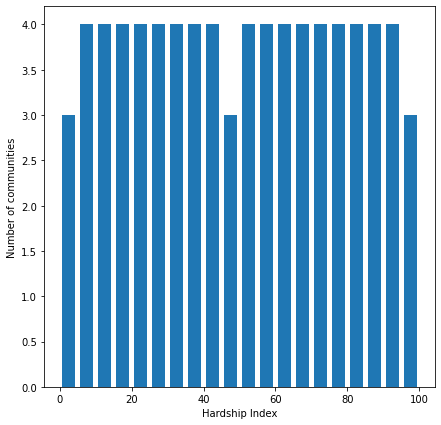

In [79]:
plt.figure(figsize=(7, 7))
plt.hist(chicago_socecon_data['HARDSHIP_INDEX'], bins=np.arange(0, 105, 5), rwidth=0.75)
plt.xlabel('Hardship Index')
plt.ylabel('Number of communities')

plt.savefig('h_index_hist.jpg')

Not very informative. The city's **communities show an even spread of the hardship index**.

Let's **plot the hardship index as a function of the percentage of people living in crowded households, as well as those living in poverty**. Simply from a reading of the description of the data, we can guess that as the percentages increase, people must feel more hardship, especially if they live under the poverty line.

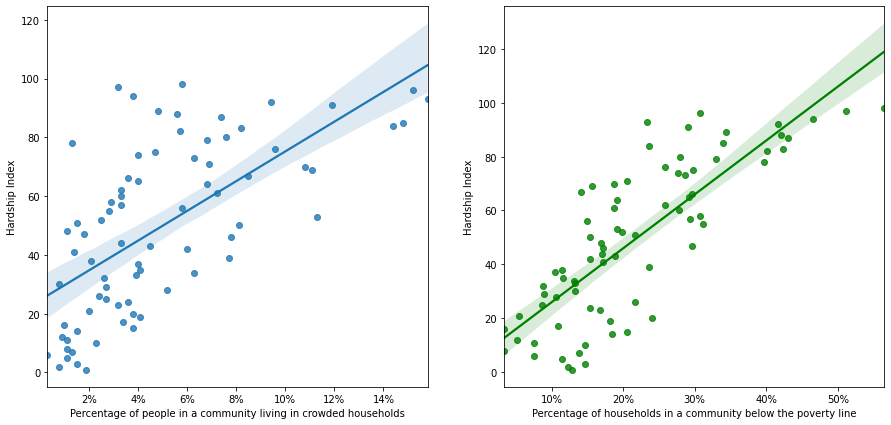

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

sns.regplot(ax=axes[0], x='PERCENT_OF_HOUSING_CROWDED', y='HARDSHIP_INDEX', data=chicago_socecon_data)
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0]
axes[0].set(xlabel='Percentage of people in a community living in crowded households', ylabel='Hardship Index')

sns.regplot(ax=axes[1], x='PERCENT_HOUSEHOLDS_BELOW_POVERTY', y='HARDSHIP_INDEX', data=chicago_socecon_data, color='g')
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set(xlabel='Percentage of households in a community below the poverty line', ylabel='Hardship Index')

plt.savefig('01.jpg')

The data corroborates our suspicions, although there are a few observations to be made.
- There is a surprising amount of variation in the hardship index of people living in crowded households. We can see that **even if a community has a low percentage of people living in cramped houses** (say ~ 1%), the **hardship index varies** from close to 0 all the way to 50, with one point even at an index of 80. It is **likely that there are other factors coming into play**. For example, people living in close quarters but not in poverty probably feel less hardship than their neighbours who do suffer from poverty.
- The correlation between the hardship index and poverty is tighter, although there is some variation, which is to be expected. Curiosly, **a community having a relatively large number of households below the poverty line (look at the data around 11-12%) can still have a hardship index close to zero**.

What's the **relationship between the age-related statistics and a community's hardship index**? Let's have a look.

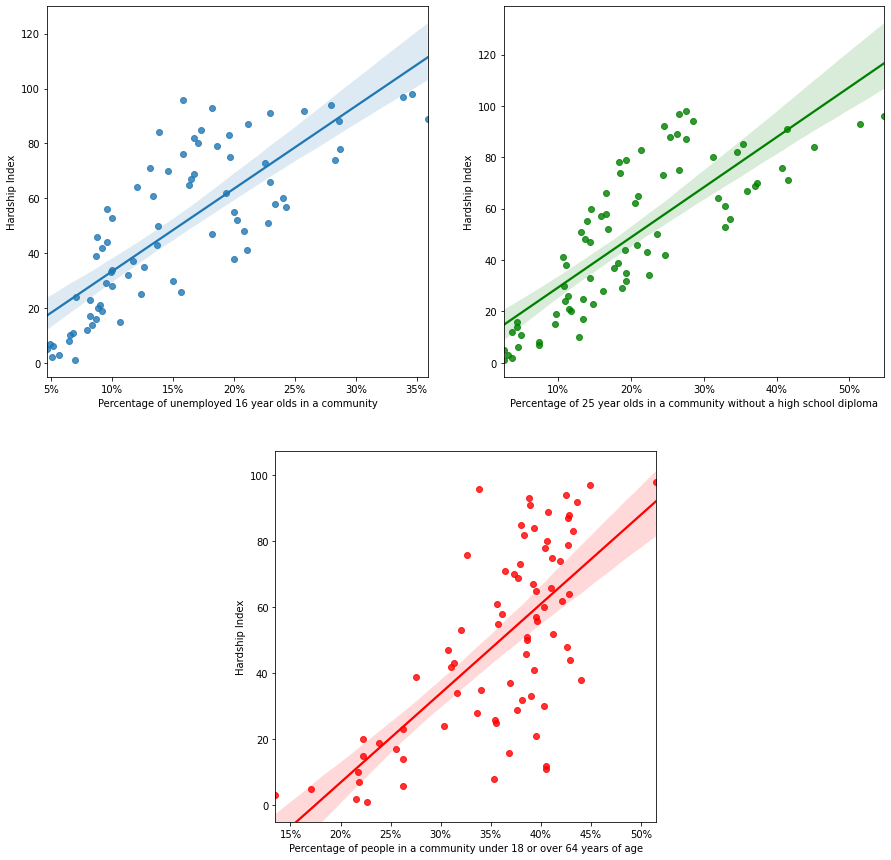

In [81]:
fig2 = plt.figure(figsize=(15, 15))
gs = fig2.add_gridspec(2, 4)

f2_ax1 = fig2.add_subplot(gs[0, :2])
f2_ax2 = fig2.add_subplot(gs[0, 2:])
f2_ax3 = fig2.add_subplot(gs[1, 1:3])

sns.regplot(ax=f2_ax1, x='PERCENT_AGED_16_UNEMPLOYED', y='HARDSHIP_INDEX', data=chicago_socecon_data)
f2_ax1.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
f2_ax1.set(xlabel='Percentage of unemployed 16 year olds in a community', ylabel='Hardship Index')

sns.regplot(ax=f2_ax2, x='PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA', y='HARDSHIP_INDEX', data=chicago_socecon_data,
            color='g')
f2_ax2.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
f2_ax2.set(xlabel='Percentage of 25 year olds in a community without a high school diploma', ylabel='Hardship Index')

sns.regplot(ax=f2_ax3, x='PERCENT_AGED_UNDER_18_OR_OVER_64', y='HARDSHIP_INDEX', data=chicago_socecon_data, color='r')
f2_ax3.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
f2_ax3.set(ylim=(-5, None))
f2_ax3.set(xlabel='Percentage of people in a community under 18 or over 64 years of age', ylabel='Hardship Index')

plt.subplots_adjust(wspace=0.5)
plt.savefig('02.jpg')

There is a positive correlation between each of the variables and the hardship index.
- **Unemployment has an obvious detrimental impact on a family or community's hardship**. We see that the absence of a job for young adults in high school (16 year olds) can place a strain on the community. The importance of a high school-level education, at minimum, is also seen in the top-right graph.
- An interesting pattern can be seen in the bottom plot. There appears to be some boundary of the **percent of people in a community either aged below 18 or above 64** (around 27-30%) below which the hardship index is contrained to be less than 20. **Once this percentage goes above 30%**, however, the hardship increases dramatically for a community. More accurately, **the *potential* for hardship increases dramatically**, since the index spans almost the entire range. Since an increase in this percentage means a larger number of people who are not in the workforce (18 being just about the age at which one would enter, and 64 being around retirement age), this correlation is not surprising.

The **effect of per capita income** on a community can be easily guessed: the more the income per capita, the easier the lives of its members should be.

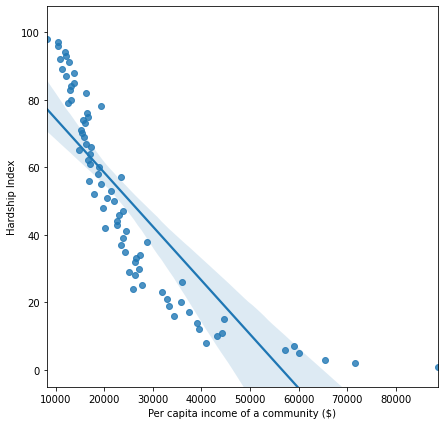

In [82]:
plt.figure(figsize=(7, 7))
sns.regplot(x=('PER_CAPITA_INCOME'), y='HARDSHIP_INDEX', data=chicago_socecon_data)
plt.ylim(-5, None)
plt.xlabel('Per capita income of a community ($)')
plt.ylabel('Hardship Index')

plt.savefig('03.jpg')

A **steep drop of the hardship index** is observed **with increasing per capita income**. **Past ~ 60,000$, it becomes effectively zero**.

Let's **examine the school data**. What is the **influence of the number of schools, attendance, and eventual college goers on the hardship index**?

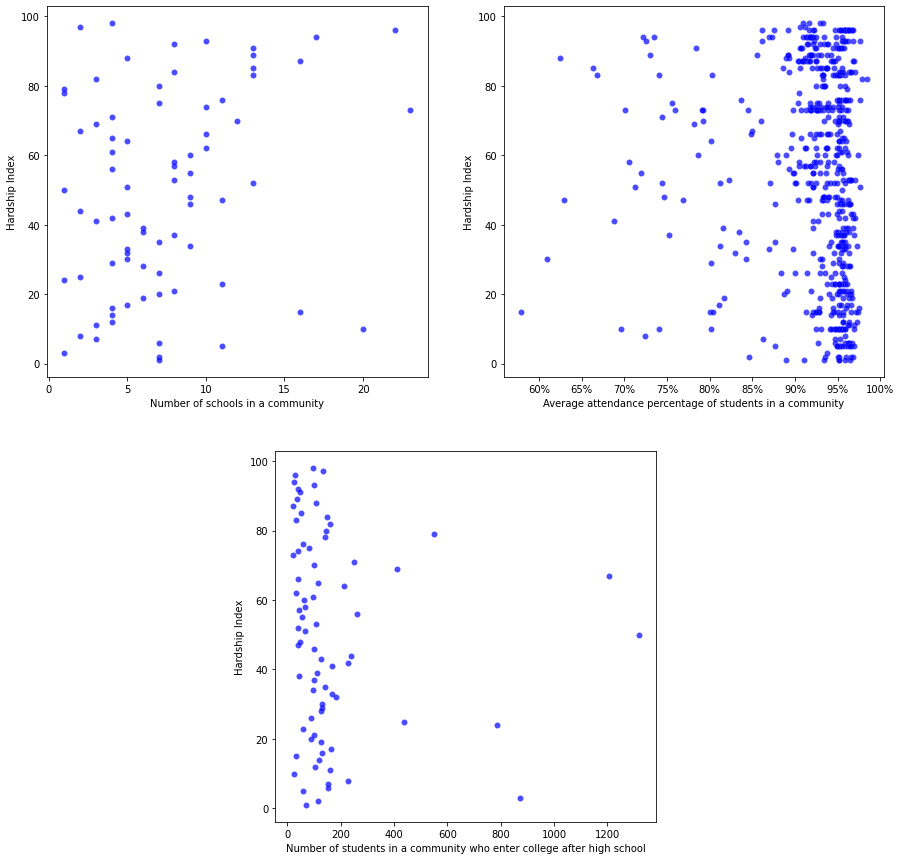

In [121]:
fig4 = plt.figure(figsize=(15, 15))
gs = fig4.add_gridspec(2, 4)

f4_ax1 = fig4.add_subplot(gs[0, :2])
f4_ax2 = fig4.add_subplot(gs[0, 2:])
f4_ax3 = fig4.add_subplot(gs[1, 1:3])

f4_ax1.scatter(x=chicago_socecon_data['NUMBER_OF_SCHOOLS'], y=chicago_socecon_data['HARDSHIP_INDEX'],
                   color="blue", edgecolors="white", linewidths=0.1, alpha=0.7)
f4_ax1.set(xlabel='Number of schools in a community', ylabel='Hardship Index')

# Need to unravel the list of average student attendance percentages for each community.
ave_att_pct = []
h_index_att = []
for i in range(len(chicago_socecon_data['AVERAGE_STUDENT_ATTENDANCE_PCT'])):
    for j in range(len(chicago_socecon_data['AVERAGE_STUDENT_ATTENDANCE_PCT'][i])):
        ave_att_pct.append(chicago_socecon_data['AVERAGE_STUDENT_ATTENDANCE_PCT'][i][j])
        h_index_att.append(chicago_socecon_data['HARDSHIP_INDEX'][i])

f4_ax2.scatter(x=ave_att_pct, y=h_index_att, color="blue", edgecolors="white", linewidths=0.1, alpha=0.7)
f4_ax2.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
f4_ax2.set(xlabel='Average attendance percentage of students in a community', ylabel='Hardship Index')

# Since the college enrollment numbers can be affected by the total number of schools in a community,
# let us average these out.
coll_enrol = []
for i in range(len(chicago_socecon_data['COLLEGE_ENROLLMENT'])):
    coll_enrol.append((mean(chicago_socecon_data['COLLEGE_ENROLLMENT'][i]))/chicago_socecon_data['NUMBER_OF_SCHOOLS'][i])

f4_ax3.scatter(x=coll_enrol, y=chicago_socecon_data['HARDSHIP_INDEX'], color="blue",
               edgecolors="white", linewidths=0.1, alpha=0.7)
f4_ax3.set(xlabel='Number of students in a community who enter college after high school', ylabel='Hardship Index')

plt.subplots_adjust(wspace=0.5)
plt.savefig('04.jpg')

We can see that **none of these factors have any impact on the hardship index**. Perhaps some pattern would emerge if we could factor in population numbers for each community as well. Unfortunately, this information is not available on the Chicago Data Portal.

Lastly, let's examine the **impact of the number of crimes on the hardship index**.

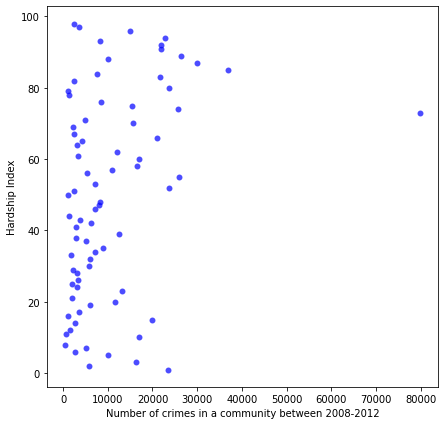

In [122]:
plt.figure(figsize=(7, 7))
plt.scatter(x=(chicago_socecon_data['NUMBER_OF_CRIMES']), y=chicago_socecon_data['HARDSHIP_INDEX'],
                   color="blue", edgecolors="white", linewidths=0.1, alpha=0.7)
plt.xlabel('Number of crimes in a community between 2008-2012')
plt.ylabel('Hardship Index')

plt.savefig('05.jpg')

Again, this **does not seem to have an impact on the hardship index**.

### Analysis<a name="goal1_analysis"></a>

We can now **pick out the variables to use** for our machine learning model: PERCENT_OF_HOUSING_CROWDED, PERCENT_HOUSEHOLDS_BELOW_POVERTY, PERCENT_AGED_16_UNEMPLOYED, PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA, PERCENT_AGED_UNDER_18_OR_OVER_64, and PER_CAPITA_INCOME. Let's extract them.

In [124]:
#Store the above independent variables in a separate DataFrame.
ml_data_x = chicago_socecon_data[['PERCENT_OF_HOUSING_CROWDED', 'PERCENT_HOUSEHOLDS_BELOW_POVERTY',
                                  'PERCENT_AGED_16_UNEMPLOYED', 'PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA',
                                  'PERCENT_AGED_UNDER_18_OR_OVER_64', 'PER_CAPITA_INCOME']].copy()
# Store the dependent/target variable, HARDSHIP_INDEX, in its own DataFrame.
ml_data_y = chicago_socecon_data[['HARDSHIP_INDEX']].copy()

Although the independent variables appear to have approximately linear correlation with the target variable, we will **try a multiple linear regression model, as well as polynomial regression models of degrees 2 & 3**. Espeially since we do not have a large dataset (only 77 data points), the **different models will then be evaluated using cross-validation**. We will **use the R<sup>2</sup> metric**.

We split the data into training and testing sets, using an 80/20 ratio, and scale it.

In [227]:
X_train, X_test, y_train, y_test = train_test_split(ml_data_x, ml_data_y, test_size=0.2, random_state=4)
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

Okay, let's cross validate a **multiple linear regression model** using the k-fold model with 5 folds.

In [235]:
lin_regr = linear_model.LinearRegression()
lin_regr_scores = cross_validate(lin_regr, X_train, y_train, cv=5, scoring='r2')
print("The cross validation scores of each fold are:", str(lin_regr_scores['test_score'])+",",
      "with an average of", str(sum(lin_regr_scores['test_score'])/len(lin_regr_scores['test_score']))+".")

The cross validation scores of each fold are: [0.97505722 0.97880506 0.9653449  0.97749285 0.94972255], with an average of 0.9692845170941414.


That's a very good score. Next, a **polynomial regression model of degree 2**.

In [236]:
poly2 = PolynomialFeatures(degree=2)
X_train_poly2 = poly2.fit_transform(X_train)
lin_regr_poly2 = linear_model.LinearRegression()
poly2_scores = cross_validate(lin_regr_poly2, X_train_poly2, y_train, cv=5, scoring='r2')
print("The cross validation scores of each fold are:", str(poly2_scores['test_score'])+",",
      "with an average of", str(sum(poly2_scores['test_score'])/len(poly2_scores['test_score']))+".")

The cross validation scores of each fold are: [0.9566159  0.91708407 0.92795959 0.9433934  0.79025116], with an average of 0.9070608226863696.


Hmm, not as good. We can see that R<sup>2</sup> shows quite sizeable fluctuations depending on the slice of data used for training: the last fold has a score of 0.79, compared to the other scores, which are all > 0.9.

What about a **polynomial regression model of degree 3**?

In [237]:
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(X_train)
lin_regr_poly3 = linear_model.LinearRegression()
poly3_scores = cross_validate(lin_regr_poly3, X_train_poly3, y_train, cv=5, scoring='r2')
print("The cross validation scores of each fold are:", str(poly3_scores['test_score'])+",",
      "with an average of", str(sum(poly3_scores['test_score'])/len(poly3_scores['test_score']))+".")

The cross validation scores of each fold are: [0.86754317 0.80185153 0.95767818 0.96246488 0.97677045], with an average of 0.9132616420610912.


We observe the same problem with R<sup>2</sup> fluctuating between folds.

So, let's **choose the multiple linear regression model**. We now run the full training set through the model, and test it.

In [238]:
lin_regr_final = linear_model.LinearRegression()
lin_regr_final.fit(X_train, y_train)
coeff = lin_regr_final.coef_
intrcpt = lin_regr_final.intercept_
print("The coefficients are", str(coeff)+".")
print("The intercept is", str(intrcpt)+".")
print()
print("The model is: HARDSHIP_INDEX = "+str(intrcpt[0])+" + ("+str(coeff[0][0])+"*PERCENT_OF_HOUSING_CROWDED)",
      "+ ("+str(coeff[0][1])+"*PERCENT_HOUSEHOLDS_BELOW_POVERTY)", "+ ("+str(coeff[0][2])+"*PERCENT_AGED_16_UNEMPLOYED)",
      "+ ("+str(coeff[0][3])+"*PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA)",
      "+ ("+str(coeff[0][4])+"*PERCENT_AGED_UNDER_18_OR_OVER_64)", "+ ("+str(coeff[0][5])+"*PER_CAPITA_INCOME)")

The coefficients are [[ 2.80125788  8.91048329  6.47346542 10.46761764  5.18869782 -1.95588027]].
The intercept is [48.50819672].

The model is: HARDSHIP_INDEX = 48.50819672131148 + (2.8012578795308127*PERCENT_OF_HOUSING_CROWDED) + (8.910483288763405*PERCENT_HOUSEHOLDS_BELOW_POVERTY) + (6.4734654167096455*PERCENT_AGED_16_UNEMPLOYED) + (10.46761764399023*PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA) + (5.188697815273462*PERCENT_AGED_UNDER_18_OR_OVER_64) + (-1.9558802655035379*PER_CAPITA_INCOME)


Let's run the test data through this model.

In [239]:
y_pred = lin_regr_final.predict(X_test)

In [240]:
print("The R\u00b2 score of the model is", r2_score(y_test, y_pred))

The R² score of the model is 0.9532214397273999


Let's **visualize the performance of the model** by plotting the predicted values versus the actual values.

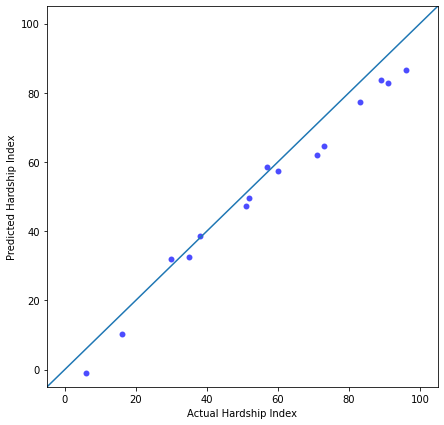

In [244]:
plt.figure(figsize=(7, 7))
plt.scatter(x=y_test, y=y_pred, color="blue", edgecolors="white", linewidths=0.1, alpha=0.7)
plt.xlim([-5, 105])
plt.ylim([-5, 105])
plt.axline((1, 1), slope=1)
plt.xlabel('Actual Hardship Index')
plt.ylabel('Predicted Hardship Index')

plt.savefig('06.jpg')

If the predicted values were exactly equal to the test values, we would get a straight line, since x=y in that case; in other words, the straight line represents a perfect fit. It seems that the model consistently underpredicts the data, evidenced by most of the points lying below the line. This is likely a consequence of the small number of data points we are working with.

## Predicting useful locations of public parks in the city<a name="goal2"></a>

### Data acquisition and cleaning<a name="goal2_data"></a>

We have the list of communities in Chicago along with their latitudes and longitudes retrieved through the geocoder module. Let's start off by creating a DataFrame that contains this information.

In [39]:
communities = chicago_socecon_data[['COMMUNITY_AREA_NAME', 'COMMUNITY_LATITUDE', 'COMMUNITY_LONGITUDE']].copy()

Okay, let's scrape Wikipedia for the list of neighbourhoods in Chicago.

In [7]:
chicago_neigh_url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago'

chicago_neigh_scrape = requests.get(chicago_neigh_url).text
soup = BeautifulSoup(chicago_neigh_scrape, 'html5lib')

In [8]:
chicago_neigh_contents = []
# Since the neighbourhoods (and the community areas they belong to) are in a table,
# search for the first instance of a table in the scraped results.
chicago_neigh = soup.find('table')
# In each 'row' (equivalent to a cell in the table on the Wikipedia page), extract the text content.
for row in chicago_neigh.findAll('td'):
    chicago_neigh_contents.append(row.text.strip())

chicago_neigh_contents

['Albany Park',
 'Albany Park',
 'Altgeld Gardens',
 'Riverdale',
 'Andersonville',
 'Edgewater',
 'Arcadia Terrace',
 'West Ridge',
 'Archer Heights',
 'Archer Heights',
 'Armour Square',
 'Armour Square',
 'Ashburn',
 'Ashburn',
 'Ashburn Estates',
 'Ashburn',
 'Auburn Gresham',
 'Auburn Gresham',
 'Avalon Park',
 'Avalon Park',
 'Avondale',
 'Avondale',
 'Avondale Gardens',
 'Irving Park',
 'Back of the Yards',
 'New City',
 'Belmont Central',
 'Belmont Cragin',
 'Belmont Gardens',
 'Hermosa',
 'Belmont Heights',
 'Dunning',
 'Belmont Terrace',
 'Dunning',
 'Beverly',
 'Beverly',
 'Beverly View',
 'Ashburn',
 'Beverly Woods',
 'Morgan Park',
 'Big Oaks',
 'Norwood Park',
 'Northalsted "Boystown"',
 'Lake View',
 'Bowmanville',
 'Lincoln Square',
 'Brainerd',
 'Washington Heights',
 'Brickyard',
 'Belmont Cragin',
 'Bridgeport',
 'Bridgeport',
 'Brighton Park',
 'Brighton Park',
 'Bronzeville',
 'Douglas',
 'Bucktown',
 'Logan Square',
 'Budlong Woods',
 'Lincoln Square',
 'Buena Par

In this list, the order of names is: neighbourhood, community, neighbourhood, community...

We can form separate lists for the neighbourhoods and communities by slicing this list, then create a DataFrame from them.

In [279]:
chicago_neighs = chicago_neigh_contents[0::2]
chicago_comms = chicago_neigh_contents[1::2]

chicago_neigh_data = pd.DataFrame(list(zip(chicago_neighs, chicago_comms)),
                                  columns = ['NEIGHBOURHOOD', 'COMMUNITY_AREA_NAME'])

In [280]:
chicago_neigh_data.head()

,NEIGHBOURHOOD,COMMUNITY_AREA_NAME
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Arcadia Terrace,West Ridge
4,Archer Heights,Archer Heights


In [281]:
chicago_neigh_data.tail()

,NEIGHBOURHOOD,COMMUNITY_AREA_NAME
242,Wildwood,Forest Glen
243,Woodlawn,Woodlawn
244,Wrightwood,Ashburn
245,Wrightwood Neighbors,Lincoln Park
246,Wrigleyville,Lake View


In [282]:
chicago_neigh_data.dtypes

NEIGHBOURHOOD          object
COMMUNITY_AREA_NAME    object
dtype: object

One problem with the scraped data is that **there are a few community names which are not present in any of the previous datasets** (census, crime, school): an example is the West Humboldt Park neighbourhood, which is part of the Austin AND Humboldt Park communities:

In [283]:
chicago_neigh_data.loc[chicago_neigh_data['NEIGHBOURHOOD']=='West Humboldt Park']

,NEIGHBOURHOOD,COMMUNITY_AREA_NAME
231,West Humboldt Park,"Austin, Humboldt Park"


Only those neighbourhoods will be retained whose community names match with the names in the census dataset, thus maintaining consistency across all datasets.

In [284]:
chicago_neigh_data = chicago_neigh_data[chicago_neigh_data.COMMUNITY_AREA_NAME.isin(census_data.COMMUNITY_AREA_NAME)]
chicago_neigh_data = chicago_neigh_data.reset_index(drop=True)

In [285]:
chicago_neigh_data

,NEIGHBOURHOOD,COMMUNITY_AREA_NAME
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Arcadia Terrace,West Ridge
4,Archer Heights,Archer Heights
...,...,...
237,Wildwood,Forest Glen
238,Woodlawn,Woodlawn
239,Wrightwood,Ashburn
240,Wrightwood Neighbors,Lincoln Park


Everything seems in order. Let's **retrieve the latitude and longitude of each neighbourhood using the geocoder module**.

In [287]:
neigh_latitudes = []
neigh_longitudes = []

for hood, comm in list(zip(chicago_neigh_data['NEIGHBOURHOOD'], chicago_neigh_data['COMMUNITY_AREA_NAME'])):
    address = "{}, {}, Chicago".format(hood, comm)
    g = geocoder.arcgis(address)
    latlng = g.latlng
    neigh_latitudes.append(latlng[0])
    neigh_longitudes.append(latlng[1])
    print(hood+", "+comm+" | Latitude: "+str(latlng[0])+", Longitude: "+str(latlng[1]))

Albany Park, Albany Park | Latitude: 41.968290000000025, Longitude: -87.72337999999996
Altgeld Gardens, Riverdale | Latitude: 41.654480000000035, Longitude: -87.60224999999997
Andersonville, Edgewater | Latitude: 41.98046000000005, Longitude: -87.66833999999994
Arcadia Terrace, West Ridge | Latitude: 41.99948000000006, Longitude: -87.69265999999999
Archer Heights, Archer Heights | Latitude: 41.811540000000036, Longitude: -87.72555999999997
Armour Square, Armour Square | Latitude: 41.834580000000074, Longitude: -87.63188999999994
Ashburn, Ashburn | Latitude: 41.74785000000003, Longitude: -87.70994999999994
Ashburn Estates, Ashburn | Latitude: 41.74785000000003, Longitude: -87.70994999999994
Auburn Gresham, Auburn Gresham | Latitude: 41.74319000000003, Longitude: -87.65503999999999
Avalon Park, Avalon Park | Latitude: 41.745070000000055, Longitude: -87.58815999999996
Avondale, Avondale | Latitude: 41.93925000000007, Longitude: -87.71124999999995
Avondale Gardens, Irving Park | Latitude: 

Irving Park, Irving Park | Latitude: 41.953550000000064, Longitude: -87.73567999999995
Irving Woods, Dunning | Latitude: 41.952740052692945, Longitude: -87.79946583797138
The Island, Austin | Latitude: 41.88775000000004, Longitude: -87.76362999999998
Jackowo, Avondale | Latitude: 41.93925000000007, Longitude: -87.71124999999995
Jackson Park Highlands, South Shore | Latitude: 41.75739000000004, Longitude: -87.58568999999994
Jefferson Park, Jefferson Park | Latitude: 41.97054000000003, Longitude: -87.76328999999998
K-Town, North Lawndale | Latitude: 41.90902960415073, Longitude: -87.7192229289752
Kelvyn Park, Hermosa | Latitude: 41.928660000000036, Longitude: -87.73771999999997
Kennedy Park, Morgan Park | Latitude: 41.68811000000005, Longitude: -87.68360999999999
Kensington, Roseland | Latitude: 41.68400091744643, Longitude: -87.61145094097408
Kenwood, Kenwood | Latitude: 41.80952000000008, Longitude: -87.59684999999996
Kilbourn Park, Irving Park | Latitude: 41.94446000000005, Longitude:

Sauganash, Forest Glen | Latitude: 41.97640000000007, Longitude: -87.75360999999998
Schorsch Forest View, O'Hare | Latitude: 41.96225045090607, Longitude: -87.84582264927626
Schorsch Village, Dunning | Latitude: 41.940460040671965, Longitude: -87.7916498937605
Scottsdale, Ashburn | Latitude: 41.74327328418575, Longitude: -87.73494309417538
Sheffield Neighbors, Lincoln Park | Latitude: 41.92173472492606, Longitude: -87.65348993598181
Sheridan Park, Uptown | Latitude: 41.969095589929246, Longitude: -87.65480077072112
Sleepy Hollow, Garfield Ridge | Latitude: 41.790760000000034, Longitude: -87.76984999999996
Smith Park, West Town | Latitude: 41.89241000000004, Longitude: -87.69165999999996
South Austin, Austin | Latitude: 41.87282900853232, Longitude: -87.77440995339975
South Chicago, South Chicago | Latitude: 41.73732000000007, Longitude: -87.55531999999994
South Commons, Douglas | Latitude: 41.840850000000046, Longitude: -87.61719999999997
South Deering, South Deering | Latitude: 41.696

**Some of the neighbourhoods have redundant coordinates**, Ashburn & Ashburn Estates, and Belmont Heights & Belmont Terrace, for example. These are clearly **neighbourhoods in close proximity** to each other. It would be a good idea to **check for duplicates**, and **pick whichever neighbourood comes first** in such redundant sets.

First, let's add the coordinate data back to the chicago_neigh_data DataFrame, then use an appropriate DataFrame method to remove duplicates.

In [288]:
chicago_neigh_data['NEIGHBOURHOOD_LATITUDE'] = neigh_latitudes
chicago_neigh_data['NEIGHBOURHOOD_LONGITUDE'] = neigh_longitudes

In [289]:
chicago_neigh_data.head()

,NEIGHBOURHOOD,COMMUNITY_AREA_NAME,NEIGHBOURHOOD_LATITUDE,NEIGHBOURHOOD_LONGITUDE
0,Albany Park,Albany Park,41.96829,-87.72338
1,Altgeld Gardens,Riverdale,41.65448,-87.60225
2,Andersonville,Edgewater,41.98046,-87.66834
3,Arcadia Terrace,West Ridge,41.99948,-87.69266
4,Archer Heights,Archer Heights,41.81154,-87.72556


In [290]:
chicago_neigh_data = chicago_neigh_data.drop_duplicates(subset=['NEIGHBOURHOOD_LATITUDE', 'NEIGHBOURHOOD_LONGITUDE'],
                                                        keep='first', ignore_index=True)

In [292]:
chicago_neigh_data.to_pickle('chicago_neigh_data.pkl')

In [9]:
chicago_neigh_data = pd.read_pickle('chicago_neigh_data.pkl')

Finally, let's **use the Foursquare API to retrieve** some information about **parks located around the neighbourhoods** of Chicago. First, a general list of venues in a neighbourhood will be retrieved, and the parks will then be picked out from them.

In [28]:
CLIENT_ID = 'NHZUROBWTGCMHI3PLUSTOG32Z2ZY5I5RETTAAITM10D54ZZS'
CLIENT_SECRET = 'DRNMYHYUC53ZHJQML4BFAKHTC1M1V30P5TY4TPJ3CPCLRZVE'
ACCESS_TOKEN = 'E2MBWP5NP3PLK4QXZDJ00KKESV0EYGUNRLEXOH0EMVVIJMFH'
VERSION = '20180604'
LIMIT = 50 # Get the 50 top venues; this is the maximum number allowed by the API with the most basic acount.

In [29]:
# Function that returns venues within a certain radius of a coordinate; the radius used here is 3 km.
def getNearbyVenues(neighborhoods, communities, latitudes, longitudes, radius=3000):
    venues_list=[]
    for neigh, comm, lat, lng in zip(neighborhoods, communities, latitudes, longitudes):        
        # Create the Foursquare API request URL.
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)    
        # Send the GET request.
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # Return relevant information for each nearby venue. 
        venues_list.append([(neigh, comm, lat, lng, v['venue']['name'], v['venue']['location']['lat'],
                             v['venue']['location']['lng'], v['venue']['location']['distance'],
                             v['venue']['categories'][0]['name']) for v in results])
        print("Retrieved venues for "+neigh+", "+comm+".")
        
    # Create a DataFrame from this list with appropriate column names.
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NEIGHBOURHOOD', 'COMMUNITY_AREA_NAME', 'NEIGHBOURHOOD_LATITUDE', 'NEIGHBOURHOOD_LONGITUDE',
                             'VENUE', 'VENUE_LATITUDE', 'VENUE_LONGITUDE', 'VENUE_DISTANCE', 'VENUE_CATEGORY']
    
    return(nearby_venues)

In [30]:
# Get nearby venues for each neighborhood in Chicago.
chicago_venues = getNearbyVenues(neighborhoods=chicago_neigh_data['NEIGHBOURHOOD'],
                                 communities=chicago_neigh_data['COMMUNITY_AREA_NAME'],
                                 latitudes=chicago_neigh_data['NEIGHBOURHOOD_LATITUDE'],
                                 longitudes=chicago_neigh_data['NEIGHBOURHOOD_LONGITUDE'])

Retrieved venues for Albany Park, Albany Park.
Retrieved venues for Altgeld Gardens, Riverdale.
Retrieved venues for Andersonville, Edgewater.
Retrieved venues for Arcadia Terrace, West Ridge.
Retrieved venues for Archer Heights, Archer Heights.
Retrieved venues for Armour Square, Armour Square.
Retrieved venues for Ashburn, Ashburn.
Retrieved venues for Auburn Gresham, Auburn Gresham.
Retrieved venues for Avalon Park, Avalon Park.
Retrieved venues for Avondale, Avondale.
Retrieved venues for Avondale Gardens, Irving Park.
Retrieved venues for Back of the Yards, New City.
Retrieved venues for Belmont Central, Belmont Cragin.
Retrieved venues for Belmont Gardens, Hermosa.
Retrieved venues for Belmont Heights, Dunning.
Retrieved venues for Beverly, Beverly.
Retrieved venues for Beverly View, Ashburn.
Retrieved venues for Beverly Woods, Morgan Park.
Retrieved venues for Big Oaks, Norwood Park.
Retrieved venues for Northalsted "Boystown", Lake View.
Retrieved venues for Bowmanville, Lincol

Retrieved venues for West Elsdon, West Elsdon.
Retrieved venues for West Englewood, West Englewood.
Retrieved venues for West Garfield Park, West Garfield Park.
Retrieved venues for West Lawn, West Lawn.
Retrieved venues for West Morgan Park, Morgan Park.
Retrieved venues for West Pullman, West Pullman.
Retrieved venues for West Ridge, West Ridge.
Retrieved venues for West Rogers Park, West Ridge.
Retrieved venues for West Town, West Town.
Retrieved venues for West Woodlawn, Woodlawn.
Retrieved venues for Wicker Park, West Town.
Retrieved venues for Woodlawn, Woodlawn.
Retrieved venues for Wrightwood, Ashburn.
Retrieved venues for Wrightwood Neighbors, Lincoln Park.
Retrieved venues for Wrigleyville, Lake View.


In [60]:
chicago_venues.shape

(17772, 9)

In [61]:
chicago_venues.head()

,NEIGHBOURHOOD,COMMUNITY_AREA_NAME,NEIGHBOURHOOD_LATITUDE,NEIGHBOURHOOD_LONGITUDE,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE,VENUE_DISTANCE,VENUE_CATEGORY
0,Albany Park,Albany Park,41.96829,-87.72338,Lawrence Fish Market,41.968280,-87.726250,237,Seafood Restaurant
1,Albany Park,Albany Park,41.96829,-87.72338,Starbucks,41.968911,-87.728817,455,Coffee Shop
2,Albany Park,Albany Park,41.96829,-87.72338,Chicago Kalbi Korean BBQ,41.968314,-87.722771,50,Korean Restaurant
3,Albany Park,Albany Park,41.96829,-87.72338,Ssyal Korean Restaurant and Ginseng House,41.968172,-87.733207,813,Korean Restaurant
4,Albany Park,Albany Park,41.96829,-87.72338,Nighthawk,41.967974,-87.713415,825,Cocktail Bar


In [62]:
chicago_venues.dtypes

NEIGHBOURHOOD               object
COMMUNITY_AREA_NAME         object
NEIGHBOURHOOD_LATITUDE     float64
NEIGHBOURHOOD_LONGITUDE    float64
VENUE                       object
VENUE_LATITUDE             float64
VENUE_LONGITUDE            float64
VENUE_DISTANCE               int64
VENUE_CATEGORY              object
dtype: object

In [63]:
chicago_venues.to_pickle('chicago_venues.pkl')

The results will now be masked for public parks. According to [the Foursquare page](https://developer.foursquare.com/docs/build-with-foursquare/categories/), parks like these will simply have the category name "Park".

In [64]:
chicago_parks = chicago_venues[chicago_venues['VENUE_CATEGORY']=='Park']

Given the radius of our search, we may get duplicate results for multiple neighbourhoods, so let's **pick out the unique parks** that the API has returned. We will do this by sorting the DataFrame by the distance between a park and the neighbourhood coordinates. Then, we pick whichever occurrence of a park comes first, since the farther away a park is, the more likely it gets picked up by the API when searching for venues in a different neghbourhood.

In [68]:
chicago_parks = chicago_parks.sort_values(by='VENUE_DISTANCE', ignore_index=True)

In [71]:
chicago_parks = chicago_parks.drop_duplicates(subset=['VENUE_LATITUDE', 'VENUE_LONGITUDE'], keep='first', ignore_index=True)

In [72]:
chicago_parks

,NEIGHBOURHOOD,COMMUNITY_AREA_NAME,NEIGHBOURHOOD_LATITUDE,NEIGHBOURHOOD_LONGITUDE,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE,VENUE_DISTANCE,VENUE_CATEGORY
0,Calumet Heights,Calumet Heights,41.733360,-87.577420,Jesse Owens Park,41.734190,-87.576949,100,Park
1,Margate Park,Uptown,41.972486,-87.652450,Margate Park,41.973362,-87.652849,102,Park
2,River's Edge,North Park,41.976232,-87.733261,Gompers Park,41.975472,-87.734078,108,Park
3,The Loop,The Loop,41.878340,-87.619970,Grant Park - Butler Field,41.879600,-87.619604,143,Park
4,Wrightwood Neighbors,Lincoln Park,41.928979,-87.656190,Jonquil Park,41.928446,-87.654580,145,Park
...,...,...,...,...,...,...,...,...,...
133,O'Hare,O'Hare,41.966250,-87.848560,Rosemont Park District - Dunne Park,41.989832,-87.863729,2909,Park
134,South Edgebrook,Forest Glen,42.002732,-87.775846,Henry Proesel Park,42.009647,-87.741880,2913,Park
135,Riverdale,Riverdale,41.644844,-87.627780,Cool County Preserves - Dixmoor Playfield,41.635334,-87.660403,2913,Park
136,West Englewood,West Englewood,41.777580,-87.667260,Marquette (Jacques) Park,41.771749,-87.701628,2926,Park


In [81]:
chicago_parks.to_pickle('chicago_parks.pkl')

### Data exploration and visualization<a name="goal2_eda_viz"></a>

Let's have a quick look at a **map of Chicago, its community areas and its neighbourhoods**.

In [98]:
chic_lat = 41.8781
chic_long = -87.6298

map_chic = folium.Map(location=[chic_lat, chic_long], zoom_start=11)

comm_group = folium.FeatureGroup(name='Community Areas')
for i in range(len(communities['COMMUNITY_AREA_NAME'])):
    comm_label = communities['COMMUNITY_AREA_NAME'][i]
    folium.Marker([communities['COMMUNITY_LATITUDE'][i], communities['COMMUNITY_LONGITUDE'][i]],
                  icon=folium.Icon(color="black", icon='glyphicon-pushpin'),
                  tooltip=comm_label).add_to(comm_group)
comm_group.add_to(map_chic)

neigh_group = folium.FeatureGroup(name='Neighbourhoods')
for i in range(len(chicago_neigh_data['NEIGHBOURHOOD'])):
    neigh_label = chicago_neigh_data['NEIGHBOURHOOD'][i]
    folium.CircleMarker([chicago_neigh_data['NEIGHBOURHOOD_LATITUDE'][i], chicago_neigh_data['NEIGHBOURHOOD_LONGITUDE'][i]],
                        radius=3, popup=neigh_label, color='blue',
                        fill=True, fill_color='#3186cc', fill_opacity=0.1).add_to(neigh_group)  
neigh_group.add_to(map_chic)
    
folium.LayerControl().add_to(map_chic)
map_chic

Let's see what the distribution of parks looks like on the map.

In [183]:
map_chic_parks = folium.Map(location=[chic_lat, chic_long], zoom_start=11)

for i in range(len(chicago_parks['VENUE'])):
    label_park = chicago_parks['VENUE'][i]
    folium.CircleMarker([chicago_parks['VENUE_LATITUDE'][i], chicago_parks['VENUE_LONGITUDE'][i]],
                        radius=3, tooltip=label_park, color='green',
                        fill=True, fill_color='#3186cc', fill_opacity=0.1).add_to(map_chic_parks)
    
map_chic_parks

A heatmap may give us more insight into the distribution of parks.

In [115]:
park_latlngs = [[p[5], p[6]] for p in chicago_parks.values]

map_chic_parks_hmap = folium.Map(location=[chic_lat, chic_long], zoom_start=11)
HeatMap(park_latlngs).add_to(map_chic_parks_hmap)

folium.Circle([41.7183, -87.6209], radius=10000, color='blue', fill=False).add_to(map_chic_parks_hmap)

map_chic_parks_hmap

We see that **there are pockets of relatively low park density, especially in the south of Chicago**.

### Analysis<a name="goal2_analysis"></a>

We will concentrate our search to the south of Chicago, centering our region of interest near the I-57/I-94 intersection; let's pick the Harlan Community Academy High School as the central point, and examine a 7.5 km radius.

We will also **need to convert latitude and longitude into Cartesian coordinates** in order to calculate distance, **and vice versa** to show the locations on a map and reverse geocode them.

In [103]:
# Function that converts latitude and longitude to Cartesian coordinates.
def latlng_to_xy(lat, lng):
    xy = utm.from_latlon(lat, lng)
    return xy[0], xy[1] # xy[0] is the x-coordinate ("Easting"), xy[1] is the y-coordinate ("Northing").

# Function that converts Cartesian coordinates to latitude and longitude.
def xy_to_latlng(x, y):
    latlng = utm.to_latlon(x, y, 16, 'T') # The UTM zone of Chicago is 16T.
    return latlng[0], latlng[1] # latlng[0] is the latitude, latlng[1] is the longitude.

# Function that calculates Cartesian distance.
def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

In [153]:
roi_center_lat = 41.7183
roi_center_lng = -87.6209
roi_center = [roi_center_lat, roi_center_lng]
roi_center_x, roi_center_y = latlng_to_xy(roi_center_lat, roi_center_lng)
roi_min_x = roi_center_x - 7500
roi_max_x = roi_center_x + 7500
roi_min_y = roi_center_y - 7500
roi_max_y = roi_center_y + 7500
roi_min_lat, roi_min_lng = xy_to_latlng(roi_min_x, roi_min_y)
roi_max_lat, roi_max_lng = xy_to_latlng(roi_max_x, roi_max_y)

In [119]:
map_roi = folium.Map(location=[chic_lat, chic_long], zoom_start=10)
 
folium.CircleMarker([roi_center_lat, roi_center_lng], radius=3, color="black",
                    tooltip='ROI Center', fill=True, fill_color='#3186cc', fill_opacity=0.7).add_to(map_roi)
folium.Marker([roi_center_lat, roi_min_lng], icon=folium.Icon(color="black", icon='glyphicon-chevron-right'),
               tooltip='ROI Westmost Point').add_to(map_roi)
folium.Marker([roi_center_lat, roi_max_lng], icon=folium.Icon(color="black", icon='glyphicon-chevron-left'),
               tooltip='ROI Eastmost Point').add_to(map_roi)
folium.Marker([roi_min_lat, roi_center_lng], icon=folium.Icon(color="black", icon='glyphicon-chevron-up'),
               tooltip='ROI Southmost Point').add_to(map_roi)
folium.Marker([roi_max_lat, roi_center_lng], icon=folium.Icon(color="black", icon='glyphicon-chevron-down'),
               tooltip='ROI Northmost Point').add_to(map_roi)
folium.Circle([41.7183, -87.6209], radius=7500, color='white', fill=False).add_to(map_roi)

map_roi

We now need a list of candidate locations. This is done by creating a hexagonal grid, with centers 1.5 km apart.

In [315]:
k = math.sqrt(3)/2 # This is the scaling factor for the vertical component of distances between hexagonal grid centers.
x_step = 1500
y_step = 1500 * k 

roi_grid_lats = []
roi_grid_lngs = []
roi_grid_xs = []
roi_grid_ys = []
for i in range(0, int(51/k)):
    y = roi_min_y + i * y_step
    x_offset = 750 if i%2==0 else 0 # Offset the centers horizontally to create a hexagonal grid.
    for j in range(0, 51):
        x = roi_min_x + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 7501):
            lat, lon = xy_to_latlng(x, y)
            roi_grid_lats.append(lat)
            roi_grid_lngs.append(lon)
            roi_grid_xs.append(x)
            roi_grid_ys.append(y)

In [184]:
map_roi_grid = folium.Map(location=roi_center, zoom_start=12)

for lat, lon in zip(roi_grid_lats, roi_grid_lngs): 
    folium.Circle([lat, lon], radius=750, color='blue', fill=False).add_to(map_roi_grid)

map_roi_grid

The approach we now take is to **count the number of parks in the vicinity of each grid cell, as well the distance to the closest park**. We can then check if there are any cells in which there are few parks nearby, and the closest park is, well, not so close by.

In [185]:
# Function that counts the number of parks within each cell.
def count_parks_nearby(x, y, chicago_parks, radius=1500):    
    count = 0
    for park in chicago_parks.values:
        park_x, park_y = latlng_to_xy(park[5], park[6])
        d_park = calc_xy_distance(x, y, park_x, park_y)
        if d_park <= radius:
            count += 1
    return count

# Function that finds the distance to the closest park.
def find_nearest_park(x, y, chicago_parks):
    d_min = 100000 # Set the minimum distance at some large value. This will get updated in the for loop.
    for park in chicago_parks.values:
        park_x, park_y = latlng_to_xy(park[5], park[6])
        d_park = calc_xy_distance(x, y, park_x, park_y)
        if d_park <= d_min:
            d_min = d_park
    return d_min

In [316]:
roi_park_counts = []
roi_park_distances = []

for x, y in zip(roi_grid_xs, roi_grid_ys):
    count = count_parks_nearby(x, y, chicago_parks, radius=1500)
    roi_park_counts.append(count)
    distance = find_nearest_park(x, y, chicago_parks)
    roi_park_distances.append(distance)

In [ ]:
roi_park_locations = pd.DataFrame({'PARK_LATITUDE': roi_grid_lats, 'PARK_LONGITUDE': roi_grid_lngs,
                                   'PARK_X': roi_grid_xs, 'PARK_Y':roi_grid_ys,
                                   'NUM_PARKS_NEARBY': roi_park_counts,
                                   'NEAREST_PARK_DISTANCE': roi_park_distances})

In [188]:
roi_park_locations.head()

,PARK_LATITUDE,PARK_LONGITUDE,PARK_X,PARK_Y,NUM_PARKS_NEARBY,NEAREST_PARK_DISTANCE
0,41.662250,-87.656395,445352.252418,4.612485e+06,0,3006.928832
1,41.662352,-87.638379,446852.252418,4.612485e+06,0,2326.010570
2,41.662450,-87.620363,448352.252418,4.612485e+06,1,882.464638
3,41.662546,-87.602347,449852.252418,4.612485e+06,2,804.464107
4,41.662639,-87.584331,451352.252418,4.612485e+06,0,1568.367827


In [189]:
roi_park_locations.tail()

,PARK_LATITUDE,PARK_LONGITUDE,PARK_X,PARK_Y,NUM_PARKS_NEARBY,NEAREST_PARK_DISTANCE
85,41.779248,-87.657587,445352.252418,4.625476e+06,1,474.864653
86,41.779350,-87.639538,446852.252418,4.625476e+06,1,1379.354387
87,41.779449,-87.621490,448352.252418,4.625476e+06,1,1412.713969
88,41.779545,-87.603441,449852.252418,4.625476e+06,2,259.031806
89,41.779639,-87.585392,451352.252418,4.625476e+06,4,278.061771


All right. In order to **narrow down the filtering criteria**, let's see how many parks a community has on average, and what the average distance to a park is.

In [207]:
chicago_parks_grouped = chicago_parks.groupby('COMMUNITY_AREA_NAME', as_index=False).agg(lambda x: list(x))
chicago_parks_grouped.head()

,COMMUNITY_AREA_NAME,NEIGHBOURHOOD,NEIGHBOURHOOD_LATITUDE,NEIGHBOURHOOD_LONGITUDE,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE,VENUE_DISTANCE,VENUE_CATEGORY
0,Albany Park,"[Ravenswood Manor, North Mayfair, Albany Park,...","[41.96509000000003, 41.97350000000006, 41.9682...","[-87.69997999999998, -87.74218999999994, -87.7...","[Ronan Park, La Bagh Woods (Cook County Forest...","[41.96962705500502, 41.978634788827435, 41.974...","[-87.70208469809673, -87.74415493011475, -87.7...","[534, 594, 673, 863, 1012]","[Park, Park, Park, Park, Park]"
1,Armour Square,[Armour Square],[41.834580000000074],[-87.63188999999994],[Armour Square Park],[41.83443196706756],[-87.6352113018499],[275],[Park]
2,Ashburn,"[Wrightwood, Wrightwood, Beverly View, Wrightw...","[41.73837000000003, 41.73837000000003, 41.7329...","[-87.70210999999995, -87.70210999999995, -87.6...","[Hayes Park, Yukich, Brainerd Park, Evergreen ...","[41.73890104881742, 41.730573362641195, 41.727...","[-87.69701256267048, -87.7027054423997, -87.65...","[427, 869, 1250, 2329]","[Park, Park, Park, Park]"
3,Auburn Gresham,[Auburn Gresham],[41.74319000000003],[-87.65503999999999],[Foster Park Field House],[41.74165820753417],[-87.65995534903145],[442],[Park]
4,Austin,"[North Austin, South Austin, South Austin, Sou...","[41.90197624615553, 41.87282900853232, 41.8728...","[-87.77534905261123, -87.77440995339975, -87.7...","[Andersen Park, Barrie Park, Columbus Park, Lo...","[41.90130767206452, 41.869730173326545, 41.875...","[-87.77870885182969, -87.77900188720794, -87.7...","[288, 513, 865, 904, 1128, 1177, 2188, 2302, 2...","[Park, Park, Park, Park, Park, Park, Park, Par..."


In [213]:
num_communities = len(chicago_parks_grouped['COMMUNITY_AREA_NAME'])

sum_parks = 0
for i in range(num_communities):
    sum_parks += len(chicago_parks_grouped['VENUE'][i])
    
ave_distance_comm = []
for i in range(num_communities):
    sum_dist = 0
    for j in range(len(chicago_parks_grouped['VENUE_DISTANCE'][i])):
        sum_dist += chicago_parks_grouped['VENUE_DISTANCE'][i][j]
    ave_distance_comm.append(sum_dist/len(chicago_parks_grouped['VENUE_DISTANCE'][i]))
    
print("The average number of parks per community is "+str(sum_parks/num_communities)+".")
print("The average distance from a community area center to a park is "+str(sum(ave_distance_comm)/num_communities)+" m.")

The average number of parks per community is 2.4210526315789473.
The average distance from a community area center to a park is 1176.8084795321636 m.


With this information, we can **restrict our search to areas with 2 parks or less and where the distance to the closest park is more than ~ 1 km**. 

In [214]:
good_park_count = np.array((roi_park_locations['NUM_PARKS_NEARBY']<=2))
print("The number of areas with 2 parks or less in their vicinity is "+str(good_park_count.sum())+".")

good_park_distance = np.array((roi_park_locations['NEAREST_PARK_DISTANCE']>=1000))
print("The number of areas where the nearest park is more than 1 km away is "+str(good_park_distance.sum())+".")

good_areas = np.logical_and(good_park_count, good_park_distance)
print("The number of areas satisfying both conditions is "+str(good_areas.sum())+".")

The number of areas with 2 parks or less in their vicinity is 88.
The number of areas where the nearest park is more than 1 km away is 63.
The number of areas satisfying both conditions is 63.


In [215]:
good_areas_df = roi_park_locations[good_areas]

These are the areas satisfying our criteria.

In [219]:
good_areas_lats = good_areas_df['PARK_LATITUDE'].values
good_areas_lngs = good_areas_df['PARK_LONGITUDE'].values

good_areas_lst = [[lat, lon] for lat, lon in zip(good_areas_lats, good_areas_lngs)]

map_good_areas = folium.Map(location=roi_center, zoom_start=12)
HeatMap(park_latlngs).add_to(map_good_areas)
folium.Circle(roi_center, radius=7500, color='white', fill=True, fill_opacity=0.6).add_to(map_good_areas)
for lat, lon in zip(good_areas_lats, good_areas_lngs):
    folium.CircleMarker([lat, lon], radius=2, color='green', fill=True, fill_color='blue',
                        fill_opacity=1).add_to(map_good_areas) 

map_good_areas

Now let's **cluster these locations** as a way to focus our search even more.

In [258]:
num_clusters = 6

good_xys = good_areas_df[['PARK_X', 'PARK_Y']].values

kmeans = KMeans(n_clusters=num_clusters, random_state=7).fit(good_xys)

cluster_centers = [xy_to_latlng(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

In [260]:
map_clusters = folium.Map(location=roi_center, zoom_start=12)
HeatMap(park_latlngs).add_to(map_good_areas)
folium.Circle(roi_center, radius=7500, color='white', fill=True, fill_opacity=0.6).add_to(map_clusters)
for cc_lat, cc_lon in cluster_centers:
    folium.Circle([cc_lat, cc_lon], radius=2000, color='green', fill=True, fill_opacity=0.25).add_to(map_clusters) 
for lat, lon in zip(good_areas_lats, good_areas_lngs):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue',
                        fill_opacity=1).add_to(map_clusters)

map_clusters

Finally, we **reverse geocode the addresses of the cluster centers**. These can be used for further investigation to determine the optimal plan of action.

In [314]:
area_suggest = []
cluster_lat_lng = [[cc_lat, cc_lon] for cc_lat, cc_lon in cluster_centers]
locator = Nominatim(user_agent='rev_geocoder')

print("These are the addresses of areas recommended for investigation:")
print()
for loc in cluster_lat_lng:
    raw_address = locator.reverse(loc)
    area_suggest.append(raw_address)
    
for i in range(len(area_suggest)):
    addr = ""
    try:
        addr += str(area_suggest[i].raw['address']['house_number'])+" "
    except KeyError:
        pass
    try:
        addr += str(area_suggest[i].raw['address']['road'])+", "
    except KeyError:
        pass
    try:
        addr += str(area_suggest[i].raw['address']['suburb'])+", "
    except KeyError:
        try:
            addr += str(area_suggest[i].raw['address']['neighbourhood'])+", "
        except:
            pass
    addr += "Chicago, Illinois "
    try:
        addr += str(area_suggest[i].raw['address']['postcode'])
    except:
        pass
    print(addr)

These are the addresses of areas recommended for investigation:

10411 South Claremont Avenue, Beverly, Chicago, Illinois 60643
1949-1951 East 78th Street, South Shore, Chicago, Illinois 60649
South Green Street, West Pullman, Chicago, Illinois 60827
234 East 95th Street, Roseland, Chicago, Illinois 60617
7359 South Carpenter Street, Englewood, Chicago, Illinois 60621
11555 South Stony Island Avenue, South Deering, Chicago, Illinois 60617


## Results and Discussion<a name="results"></a>

The analysis has yielded insight into the factors that have the greatest effect on the economic hardship of a community, represented by the hardship index metric. Aside from what may perhaps be an obvious factor, living below the poverty line, it is observed that household density, percentage of community members not in the workforce, education level, and per capita income impact this metric strongly. By training a multiple linear regression model on data between 2008-2012 from the city of Chicago, a fairly robust predictive pipeline has been demonstrated, in spite of the small size of the dataset. As mentioned, access to details of population by community area could help in pinpointing other factors on which the hardship index in dependent. A single value of the metric was provided over the four year period for each community, resulting in the non-ideal amount of data. Access to multiple years' worth of the metric would allow for a more precise and generalized evaluation of the socio-economic conditions of a community.

Armed with the well-established fact of the beneficial effects of having parks in a community, the study then tackled the problem of finding new areas to open parks for public access. By performing a geospatial analysis of the city, it is evident that parts of the south have space for this. Dividing this area into search grids and performing k-means clustering on the results provided six candidate zones which can be investigated further. The final decission will have to take other factors into consideration: geographical suitability, real estate availability, and prices, for example.

## Conclusion<a name="conclusion"></a>

This study had two aims: analyzing the socio-economic factors that affect the well-being of a community's members, developing a predictive model in the process, and to find areas lacking in public parks, enabling municipal powers to be proactive in providing this proven resource to their constituencies.

The result of pursuing the first aim, a linear regression model that can predict the hardship index of a comunity based on socio-economic statistics, can be very useful to government, for example, in order to improve their policies so that communities provide a healthy, nurturing environment for its residents. Pursuing the second aim led to an algorithmic way to find areas lacking a particular resource, providing a great starting point for action. Although parks in Chicago were used in this study, the methodology can be utilized for any public good.